In [1]:
pip install pytrends

Note: you may need to restart the kernel to use updated packages.


In [16]:
import datetime
from functools import reduce
import pandas as pd
from pytrends.request import TrendReq
from pytz import timezone
import numpy as np
import os
import re
import matplotlib.pyplot as plt

# Google trends 

In [3]:
test_trends1 = ["anxieté", "depression", "suicide", "bipolaire", "angoisse", "sertraline" ]

test_trends2 = ["sensation", "futur", "optimisme", "depression", "ambiguite"]

In [4]:
pytrends = TrendReq(hl="en-US", tz=360)

In [5]:
#can drop this function in the future , not very useful for now 
def set_date_range(start, end, interval):
    difference = (end  - start ) / interval
    for i in range(interval):
        yield (start + difference *i).strftime("%Y%m%d")
    yield end.strftime("%Y%m%d")

In [6]:
country_dataframes = []
for country_file in os.listdir("country_covid"):
    country_dataframes.append(pd.read_csv(f'country_covid/{country_file}'))

covid_france = country_dataframes[0]
covid_germany = country_dataframes[1]
covid_uk =  country_dataframes[2]

In [7]:
#Get time frame of covid dataframes 
daily_timeframe = pd.date_range(start=country_dataframes[0]["date"].min(), 
                                end=country_dataframes[0]["date"].max(),
                                freq="D",
                                name="daily_timeframe")

In [8]:
#need to create 3 time frames:

# "timeframe" = the entire time frame of country_dataframe I.E the time range of the data we got
#                                                                               for each country

timeframe = str(daily_timeframe.min().strftime("%Y-%m-%d"))
timeframe = timeframe + " " + str(daily_timeframe.max().strftime("%Y-%m-%d"))


# we must split the timeframe in two. Other wise Google trends does not provide daily data
# for such a long time

mid_point = list(set_date_range(daily_timeframe.min(),
                                daily_timeframe.max(), interval=2))[1]

time_half_1 = str(daily_timeframe.min().strftime("%Y-%m-%d")) 
time_half_1 = time_half_1 + " " + str(pd.to_datetime(mid_point).strftime("%Y-%m-%d"))

time_half_2 = str((pd.to_datetime(mid_point)+datetime.timedelta(days=1)).strftime("%Y-%m-%d")) 
time_half_2 = time_half_2 + " " + str(daily_timeframe.max().strftime("%Y-%m-%d"))

In [9]:
def fetch_word(timeframe: list):
    kw_word = [input("Enter word to add to df: ")]
    pytrends.build_payload(kw_list=kw_word,
                                   cat=0,
                                   timeframe=timeframe,
                                   geo="FR",
                                   gprop="")
    data = pytrends.interest_over_time()
    data.reset_index(inplace=True)
    data.drop("isPartial", axis=1, inplace=True)
    return data

In [10]:
#by default : google trends aggregates time period to weeks if time period > 7 months & < 2 years
#this is weekly data for a time_frame this size 

def fetch_data(timeframe: str, words: list): 
    trends = []
    for word in words:
        pytrends.build_payload(kw_list = [word],
                               cat=0,
                               timeframe=timeframe,
                               geo="FR",
                               gprop="")
        word_trend = pytrends.interest_over_time()
        word_trend.reset_index(inplace=True)
        word_trend.drop("isPartial", axis=1, inplace=True)
        
        trends.append(word_trend)
        
    trends_merged = reduce(lambda trend_left, trend_right: pd.merge(trend_left,
                                                                    trend_right,
                                                                    on="date",
                                                                    how="inner"), trends)
    return trends_merged

In [11]:
def fetch_daydata(words :list):
    
    day_data = fetch_data(time_half_1, words).append(fetch_data(time_half_2, words))
    day_data = day_data.reset_index().drop("index", axis=1)
    
    return day_data

In [12]:
def aggregate_data(words : list):
    
    clean_words = []
    clean_word_trends = []
    agg_trends = []

    dirty_trends = pd.merge(fetch_daydata(words), fetch_data(timeframe, words),
                             on="date",
                             how="outer",
                             suffixes=["_day", "_week"])
    dirty_trends.fillna(method="ffill", inplace=True)
    
    base_timeframe = dirty_trends[["date"]]
    base_timeframe.reset_index(inplace=True)
    
    for word in words:
        clean_words.append(word.split("_")[0])
    
    for clean_word in clean_words:
        
        #problem here with regex below. It isn't perfect a perfect match regex 
        #need to change in the futur
        #if user types similar words in google trend research bar , for example : 
        # "depression" AND "deprime" then filter takes 4 columns instead of 2
        
        clean_trends = dirty_trends.filter(regex=clean_word, axis=1)
        clean_word_trends.append(clean_trends)

    for trend in clean_word_trends:
        daily_value = trend[trend.columns[0]]
        daily_value.replace([0], 1, inplace = True)
        
        weekly_value = trend[trend.columns[1]]
        weekly_value.replace([0] , 1, inplace=True)
        
        trend.dropna(inplace=True)
        trend_name = trend.columns[0].split("_")[0]
        
        trend[f"agg_{trend_name}"] = daily_value * weekly_value / 100

    for trend in clean_word_trends:
        agg_columns = trend.filter(regex="agg_", axis=1)
        agg_trends.append(agg_columns)

    agg_dataframe = reduce(lambda trend_left, trend_right: trend_left.join(trend_right), 
                                        agg_trends)
    agg_dataframe.reset_index(inplace=True)
    agg_dataframe = base_timeframe.merge(agg_dataframe, on = "index", how = "right")
    
    
    
    return agg_dataframe

In [82]:
words = ["anxiete", "depression", "suicide", "mort", "docteur", "psycologue",
          "sertraline", "timide"]
df_keyword = aggregate_data(words)
df_keyword 

/Users/mengxiangyong/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-12-6d0b3a3260cd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend.dropna(inplace=True)
<ipython-input-12-6d0b3a3260cd>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend[f"agg_{trend_name}"] = d

,index,date,agg_anxiete,agg_depression,agg_suicide,agg_mort,agg_docteur,agg_psycologue,agg_sertraline,agg_timide
0,4,2020-03-22,48.36,28.67,6.40,74.00,20.80,2.60,3.64,19.32
1,5,2020-03-23,29.64,20.74,5.12,61.00,39.00,2.20,0.26,32.43
2,6,2020-03-24,16.12,34.16,4.48,66.00,32.50,4.60,6.24,8.28
3,7,2020-03-25,16.12,40.26,6.72,59.00,29.25,2.30,0.26,25.53
4,8,2020-03-26,5.20,23.79,6.40,60.00,28.60,0.10,0.26,34.50
...,...,...,...,...,...,...,...,...,...,...
385,389,2021-04-11,13.44,65.60,17.86,34.30,26.25,0.71,16.38,5.36
386,390,2021-04-12,12.80,38.54,10.81,24.99,66.75,0.71,20.16,9.38
387,391,2021-04-13,44.16,60.68,9.87,24.50,57.75,35.50,5.04,32.83
388,392,2021-04-14,12.80,43.46,8.46,26.46,55.50,61.06,15.54,38.86


In [85]:
def graph_n(words : list):
    plt.figure(figsize=(50,50),dpi=100)   
    for i in range(len(words)):
        plt.subplot(len(words),1,i+1)
        plt.plot(df_keyword['date'],df_keyword[df_keyword.columns[i+2]])
        plt.xlabel('date')
        plt.ylabel('Rate')
        plt.yticks(range(100,20))
        plt.title('rate of word ' + words[i] + ' by date')
        
        plt.savefig('./test2.jpg')
        
    
    


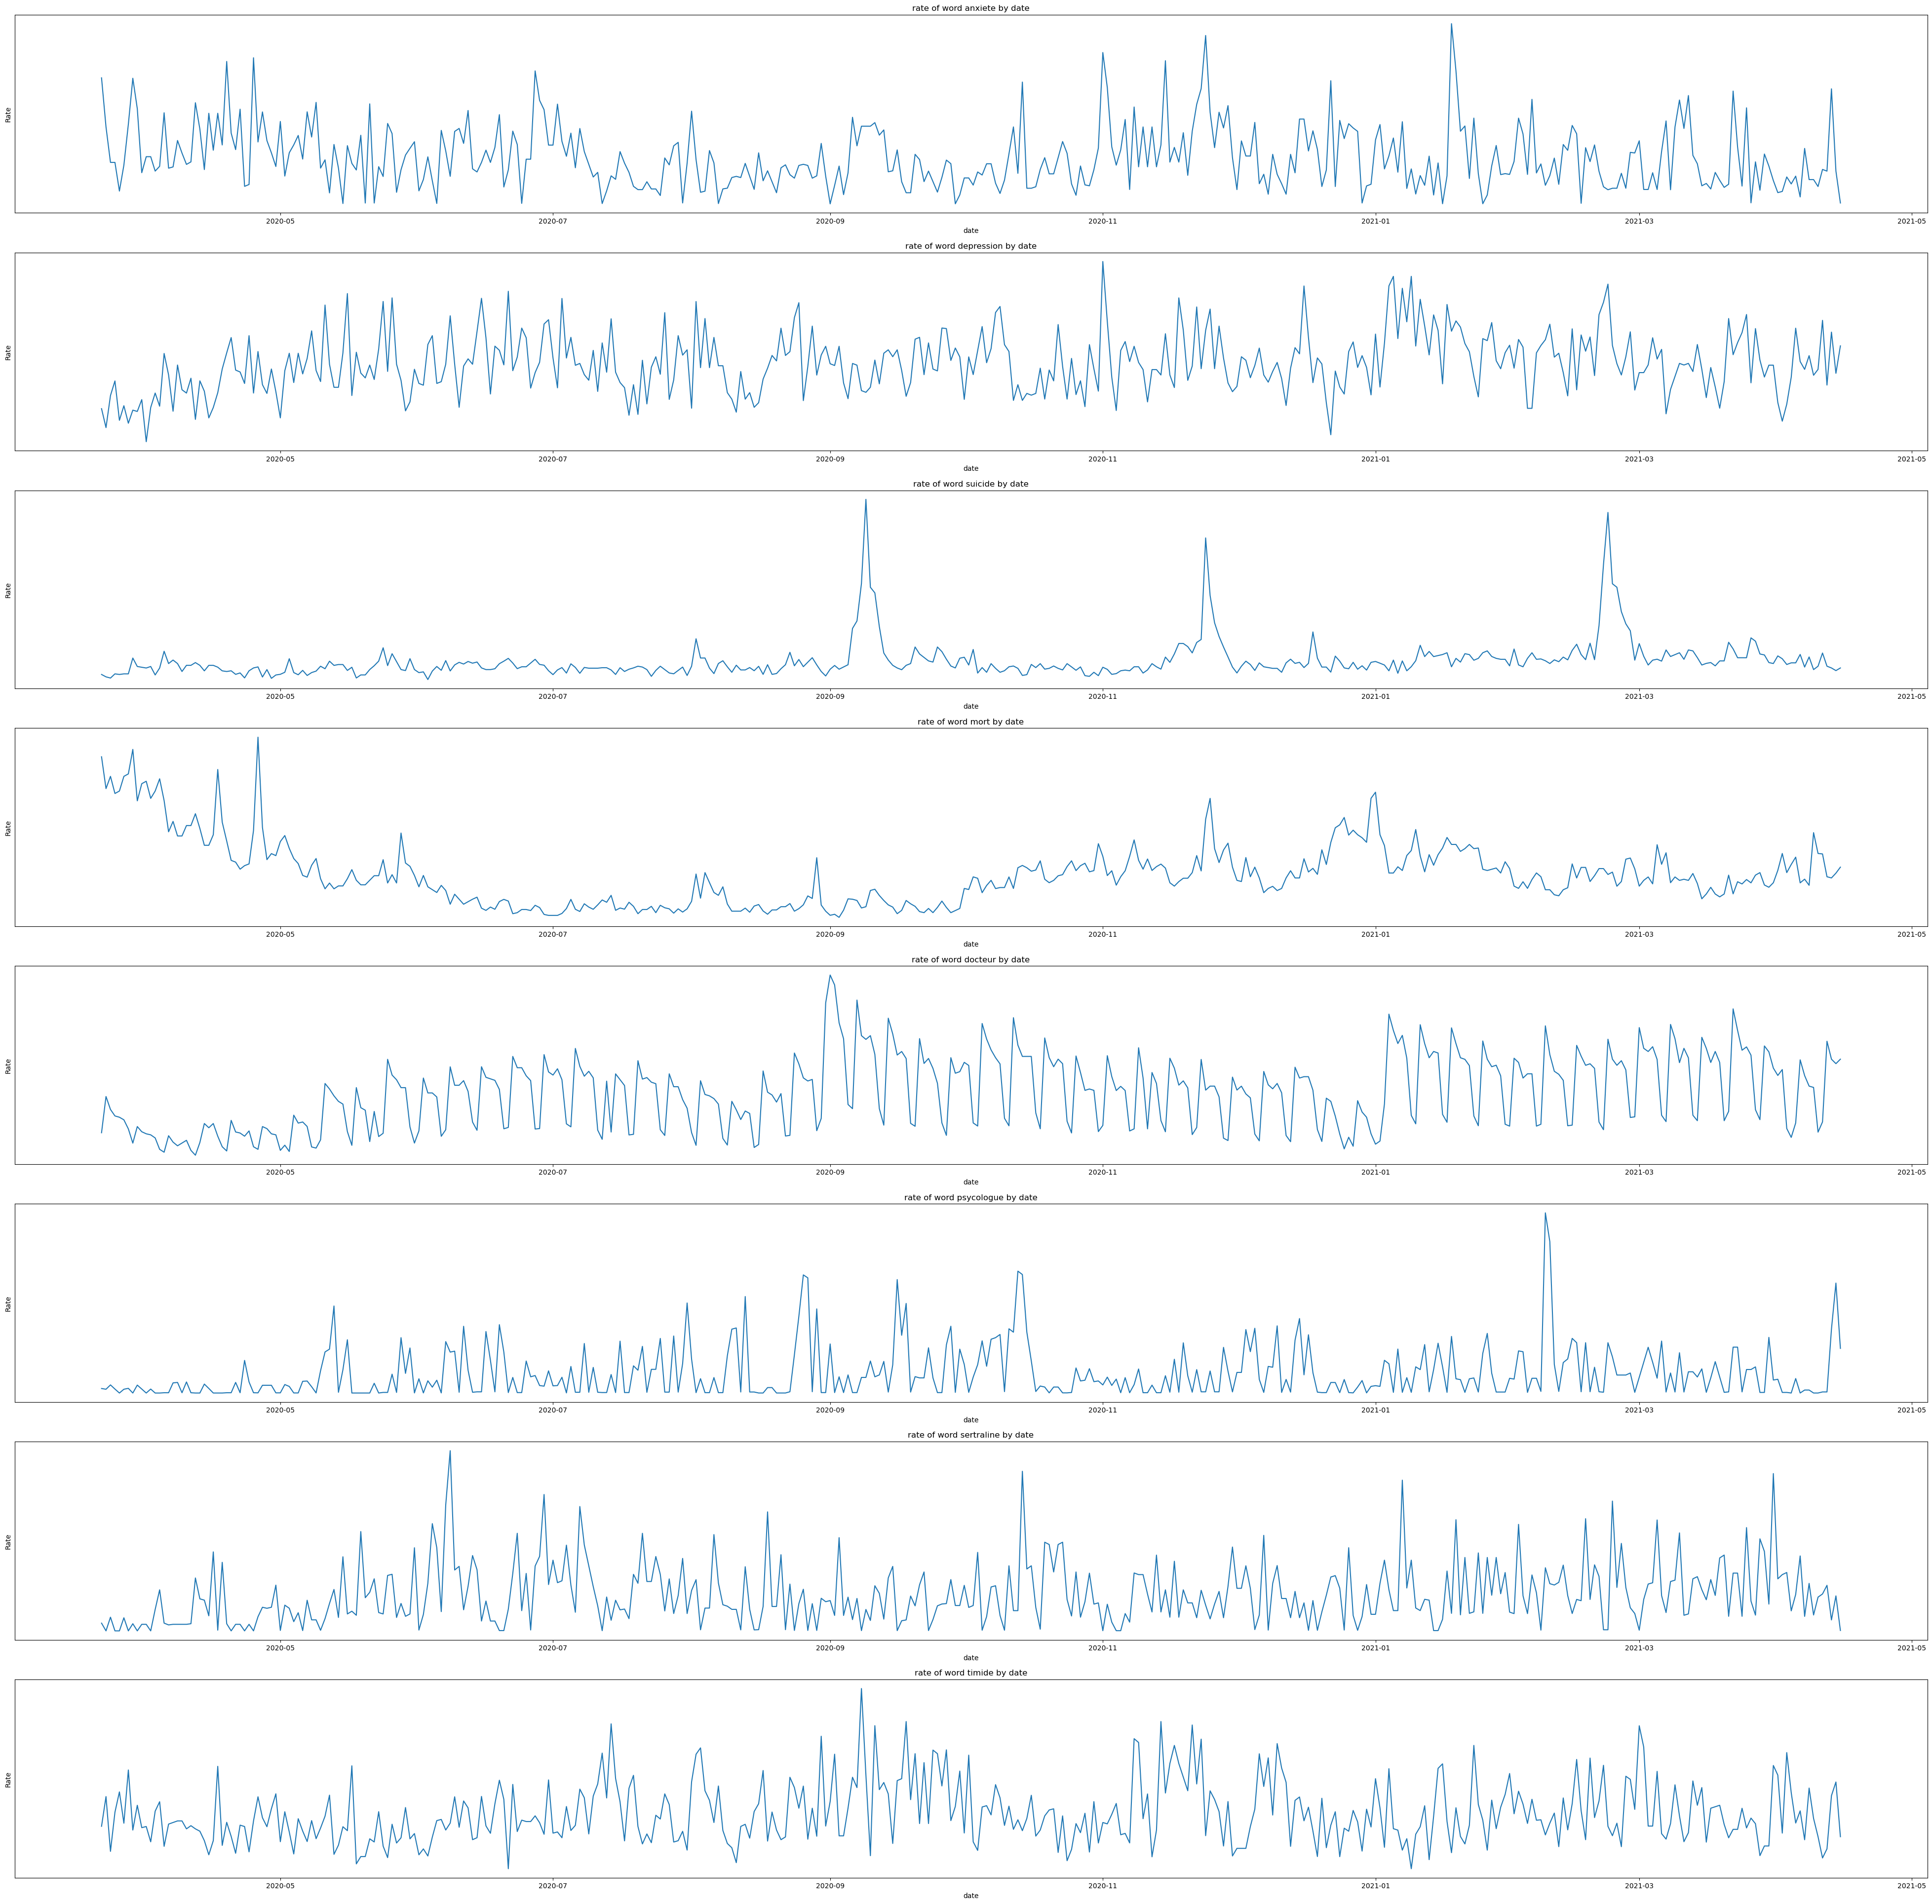

In [86]:
graph_n(words)